# Notebook 2: Revenue Modeling (The Top Line).


In this notebook, we've successfully transformed our static "Asset Roster" into a dynamic "Cash Flow Schedule." This is a crucial step in any DCF model.

Key Logic Applied:

* Explosion: We took each reactor and "exploded" it into future years based on its Remaining_Life. A reactor with 20 years left now has 20 rows in our dataset, one for each year of operation.

* Steady State Assumption: We assumed that future performance (Load Factor) will mirror the recent 5-year average. This is a standard industry practice for mature assets.

* Sensitivity: We modeled three "Busbar Price" scenarios ($50, $75, $100 per MWh) to bracket the potential revenue.

Block 1: Setup & Data Loading

We define our global valuation start year (2025) and our power price scenarios.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 2: Revenue Modeling (The Top Line) ---")

# 1. Load the Fleet Roster from Notebook 1
try:
    df_roster = pd.read_csv('fleet_roster.csv')
    print("Fleet Roster loaded successfully.")
except FileNotFoundError:
    print("Error: 'fleet_roster.csv' not found. Please run Notebook 1 first.")

# 2. Define Valuation Parameters
CURRENT_YEAR = 2025

# Power Price Scenarios ($/MWh)
# These are "busbar" prices (wholesale electricity prices)
# Sensitivity Analysis is crucial for valuation
POWER_PRICES = {
    'Bear_Case': 50,   # Cheap gas/renewables suppress prices
    'Base_Case': 75,   # Sustainable long-term average
    'Bull_Case': 100   # High demand/Carbon pricing premium
}

print(f"Valuation Start Year: {CURRENT_YEAR}")
print(f"Price Scenarios: {POWER_PRICES}")
print(df_roster.head())

--- Notebook 2: Revenue Modeling (The Top Line) ---
Fleet Roster loaded successfully.
Valuation Start Year: 2025
Price Scenarios: {'Bear_Case': 50, 'Base_Case': 75, 'Bull_Case': 100}
           Reactor name Country Type  Net Capacity, MWe Grid Connection Date  \
0  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
1  AKADEMIK LOMONOSOV-2  RUSSIA  PWR                 32           2019-12-19   
2             ALMARAZ-1   SPAIN  PWR               1011           1981-05-01   
3             ALMARAZ-2   SPAIN  PWR               1006           1983-10-08   
4               ANGRA-1  BRAZIL  PWR                609           1982-04-01   

   Avg_Load_Factor  Age  Assumed_Lifespan  Remaining_Life  
0            35.62    6                60              54  
1            27.04    6                60              54  
2            85.84   44                60              16  
3            90.14   42                60              18  
4            87.52   43             

Block 2: Generate Cash Flow Schedule

This block creates the time-series structure. It takes 415 reactors and turns them into ~12,000 annual projection records.

In [7]:
print("Expanding Fleet Roster into Annual Cash Flow Schedule...")

# We need to "explode" each reactor row into N rows, where N = Remaining_Life
# This creates a year-by-year schedule for our DCF

# 1. Filter for assets with life remaining
active_roster = df_roster[df_roster['Remaining_Life'] > 0].copy()

# 2. Create a list of years for each reactor
# If Remaining Life is 10, create [2025, 2026, ... 2034]
def generate_years(row):
    return list(range(CURRENT_YEAR, CURRENT_YEAR + int(row['Remaining_Life'])))

active_roster['Projection_Year'] = active_roster.apply(generate_years, axis=1)

# 3. Explode the dataframe to create one row per projection year
df_schedule = active_roster.explode('Projection_Year')

print(f"Created detailed schedule with {len(df_schedule)} annual projection records.")
print(df_schedule[['Reactor name', 'Projection_Year', 'Remaining_Life']].head(10))

Expanding Fleet Roster into Annual Cash Flow Schedule...
Created detailed schedule with 11966 annual projection records.
           Reactor name Projection_Year  Remaining_Life
0  AKADEMIK LOMONOSOV-1            2025              54
0  AKADEMIK LOMONOSOV-1            2026              54
0  AKADEMIK LOMONOSOV-1            2027              54
0  AKADEMIK LOMONOSOV-1            2028              54
0  AKADEMIK LOMONOSOV-1            2029              54
0  AKADEMIK LOMONOSOV-1            2030              54
0  AKADEMIK LOMONOSOV-1            2031              54
0  AKADEMIK LOMONOSOV-1            2032              54
0  AKADEMIK LOMONOSOV-1            2033              54
0  AKADEMIK LOMONOSOV-1            2034              54


Block 3: Revenue Calculation

We calculate the Annual_Generation_MWh (the physical product) and then multiply by our price scenarios to get the top-line revenue.

In [8]:
print("Calculating Future Revenue Streams...")

# 1. Calculate Annual Generation (MWh)
# MWh = MW * 8760 hours/year * Load Factor
# We use the 'Avg_Load_Factor' calculated in NB1 as the steady-state performance assumption
df_schedule['Annual_Generation_MWh'] = (
    df_schedule['Net Capacity, MWe'] * 8760 * (df_schedule['Avg_Load_Factor'] / 100)
)

# 2. Calculate Revenue for Each Scenario
for scenario, price in POWER_PRICES.items():
    col_name = f'Revenue_{scenario}'
    df_schedule[col_name] = df_schedule['Annual_Generation_MWh'] * price

# 3. Add Cumulative Revenue (just for quick sanity check)
df_schedule['Cumulative_Revenue_Base'] = df_schedule.groupby('Reactor name')['Revenue_Base_Case'].cumsum()

print("Revenue calculation complete.")
print(df_schedule[['Reactor name', 'Projection_Year', 'Annual_Generation_MWh', 'Revenue_Base_Case']].head())

Calculating Future Revenue Streams...
Revenue calculation complete.
           Reactor name Projection_Year  Annual_Generation_MWh  \
0  AKADEMIK LOMONOSOV-1            2025              99849.984   
0  AKADEMIK LOMONOSOV-1            2026              99849.984   
0  AKADEMIK LOMONOSOV-1            2027              99849.984   
0  AKADEMIK LOMONOSOV-1            2028              99849.984   
0  AKADEMIK LOMONOSOV-1            2029              99849.984   

   Revenue_Base_Case  
0          7488748.8  
0          7488748.8  
0          7488748.8  
0          7488748.8  
0          7488748.8  


Block 4: Visualization & Export

We visualize the aggregate revenue curve.

Visualizing Global Fleet Revenue Projections...


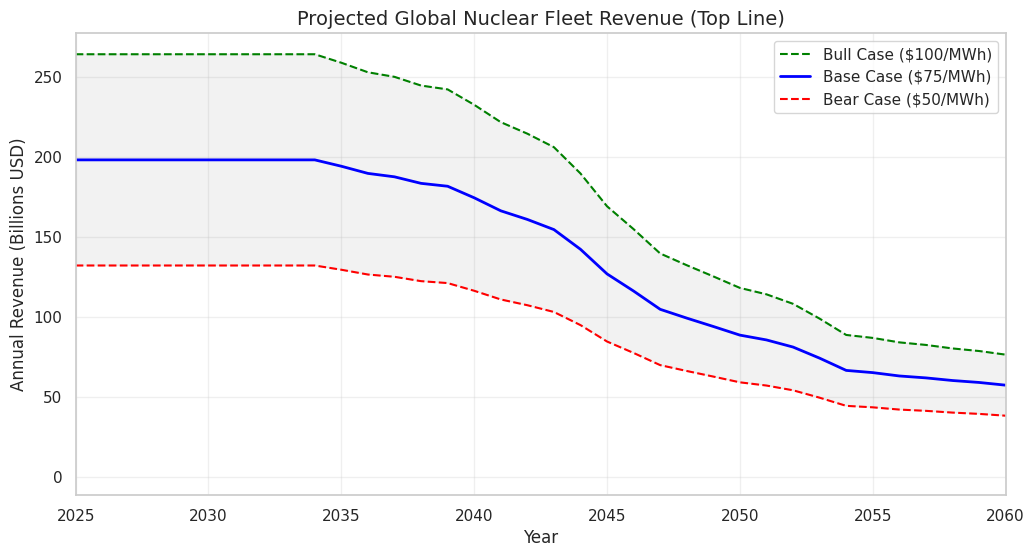

Revenue Projections saved to 'fleet_revenue_projections.csv'. Ready for Notebook 3.


In [9]:
print("Visualizing Global Fleet Revenue Projections...")

# 1. Aggregate Revenue by Year (Global Total)
global_revenue = df_schedule.groupby('Projection_Year')[['Revenue_Bear_Case', 'Revenue_Base_Case', 'Revenue_Bull_Case']].sum().reset_index()

# Convert to Billions for readability
global_revenue['Revenue_Bear_Case'] /= 1e9
global_revenue['Revenue_Base_Case'] /= 1e9
global_revenue['Revenue_Bull_Case'] /= 1e9

# 2. Plot: The Revenue Decline Curve
plt.figure(figsize=(12, 6))
plt.plot(global_revenue['Projection_Year'], global_revenue['Revenue_Bull_Case'], label='Bull Case ($100/MWh)', color='green', linestyle='--')
plt.plot(global_revenue['Projection_Year'], global_revenue['Revenue_Base_Case'], label='Base Case ($75/MWh)', color='blue', linewidth=2)
plt.plot(global_revenue['Projection_Year'], global_revenue['Revenue_Bear_Case'], label='Bear Case ($50/MWh)', color='red', linestyle='--')

plt.fill_between(global_revenue['Projection_Year'], global_revenue['Revenue_Bear_Case'], global_revenue['Revenue_Bull_Case'], color='gray', alpha=0.1)

plt.title('Projected Global Nuclear Fleet Revenue (Top Line)', fontsize=14)
plt.ylabel('Annual Revenue (Billions USD)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(CURRENT_YEAR, 2060) # Focus on the relevant horizon
plt.show()

# 3. Export the Schedule
# We need this detailed schedule for the Cost Modeling notebook
df_schedule.to_csv('fleet_revenue_projections.csv', index=False)
print("Revenue Projections saved to 'fleet_revenue_projections.csv'. Ready for Notebook 3.")

Analysis: The resulting chart shows a steady decline in revenue starting around 2035-2040. This corresponds to the "Asset Cliff" we saw in Notebook 1. This is the "Business as Usual" case without new builds—essentially the liquidation value of the current industry.